# Сверточная нейронная сеть для распознавания дорожных знаков

Выполнил студент 545а группы, Скрынник Е.И.

Начинаем с импорта всех необходимых для обучения нейросети библиотек:

In [ ]:
!pip install visualkeras

from google.colab import files
import numpy as np
import pandas as pd
import os
import cv2
import visualkeras
import matplotlib.pyplot as plt
import tensorflow as tf
import random
from tensorflow import keras
from PIL import Image
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import accuracy_score
from matplotlib.image import imread
np.random.seed(42)

from matplotlib import style
style.use('fivethirtyeight')

## Подготовка изображений для обучения нейросети

Загружаем изображения для обучения:

In [ ]:
os.environ['KAGGLE_CONFIG_DIR'] = "/content"
!mkdir TrafficSignRecognitionDataset
%cd TrafficSignRecognitionDataset
!kaggle datasets download -d meowmeowmeowmeowmeow/gtsrb-german-traffic-sign
!unzip \*.zip  && rm *.zip

Выходные данные были обрезаны до нескольких последних строк (5000).
  inflating: train/5/00005_00053_00010.png  
  inflating: train/5/00005_00053_00011.png  
  inflating: train/5/00005_00053_00012.png  
  inflating: train/5/00005_00053_00013.png  
  inflating: train/5/00005_00053_00014.png  
  inflating: train/5/00005_00053_00015.png  
  inflating: train/5/00005_00053_00016.png  
  inflating: train/5/00005_00053_00017.png  
  inflating: train/5/00005_00053_00018.png  
  inflating: train/5/00005_00053_00019.png  
  inflating: train/5/00005_00053_00020.png  
  inflating: train/5/00005_00053_00021.png  
  inflating: train/5/00005_00053_00022.png  
  inflating: train/5/00005_00053_00023.png  
  inflating: train/5/00005_00053_00024.png  
  inflating: train/5/00005_00053_00025.png  
  inflating: train/5/00005_00053_00026.png  
  inflating: train/5/00005_00053_00027.png  
  inflating: train/5/00005_00053_00028.png  
  inflating: train/5/00005_00053_00029.png  
  inflating: train/5/00005_00054

Задаем параметры(путь к набору данных, размеры изображений):

In [ ]:
# Каталог с загруженными данными
data_dir = os.curdir
# Каталог с данными для обучения
train_path = 'Train'
# Каталог с данными для тестирования
test_path = 'Test'

# Устанавливаем размер изображения 32х32
image_height = 32
image_width = 32
# Количество каналов в изображении: RGB
channels = 3


Считаем количество классов а исходном наборе данных:

In [ ]:
classes_amount = len(os.listdir(train_path))
classes_amount

43

Указываем названия классов набора данных:

In [ ]:
# Классы изображений в наборе данных
classes = { 0:'Speed limit (20km/h)',
            1:'Speed limit (30km/h)', 
            2:'Speed limit (50km/h)', 
            3:'Speed limit (60km/h)', 
            4:'Speed limit (70km/h)', 
            5:'Speed limit (80km/h)', 
            6:'End of speed limit (80km/h)', 
            7:'Speed limit (100km/h)', 
            8:'Speed limit (120km/h)', 
            9:'No passing', 
            10:'No passing veh over 3.5 tons', 
            11:'Right-of-way at intersection', 
            12:'Priority road', 
            13:'Yield', 
            14:'Stop', 
            15:'No vehicles', 
            16:'Veh > 3.5 tons prohibited', 
            17:'No entry', 
            18:'General caution', 
            19:'Dangerous curve left', 
            20:'Dangerous curve right', 
            21:'Double curve', 
            22:'Bumpy road', 
            23:'Slippery road', 
            24:'Road narrows on the right', 
            25:'Road work', 
            26:'Traffic signals', 
            27:'Pedestrians', 
            28:'Children crossing', 
            29:'Bicycles crossing', 
            30:'Beware of ice/snow',
            31:'Wild animals crossing', 
            32:'End speed + passing limits', 
            33:'Turn right ahead', 
            34:'Turn left ahead', 
            35:'Ahead only', 
            36:'Go straight or right', 
            37:'Go straight or left', 
            38:'Keep right', 
            39:'Keep left', 
            40:'Roundabout mandatory', 
            41:'End of no passing', 
            42:'End no passing veh > 3.5 tons' }

Визуализируем количество изображений каждого класса на графике:

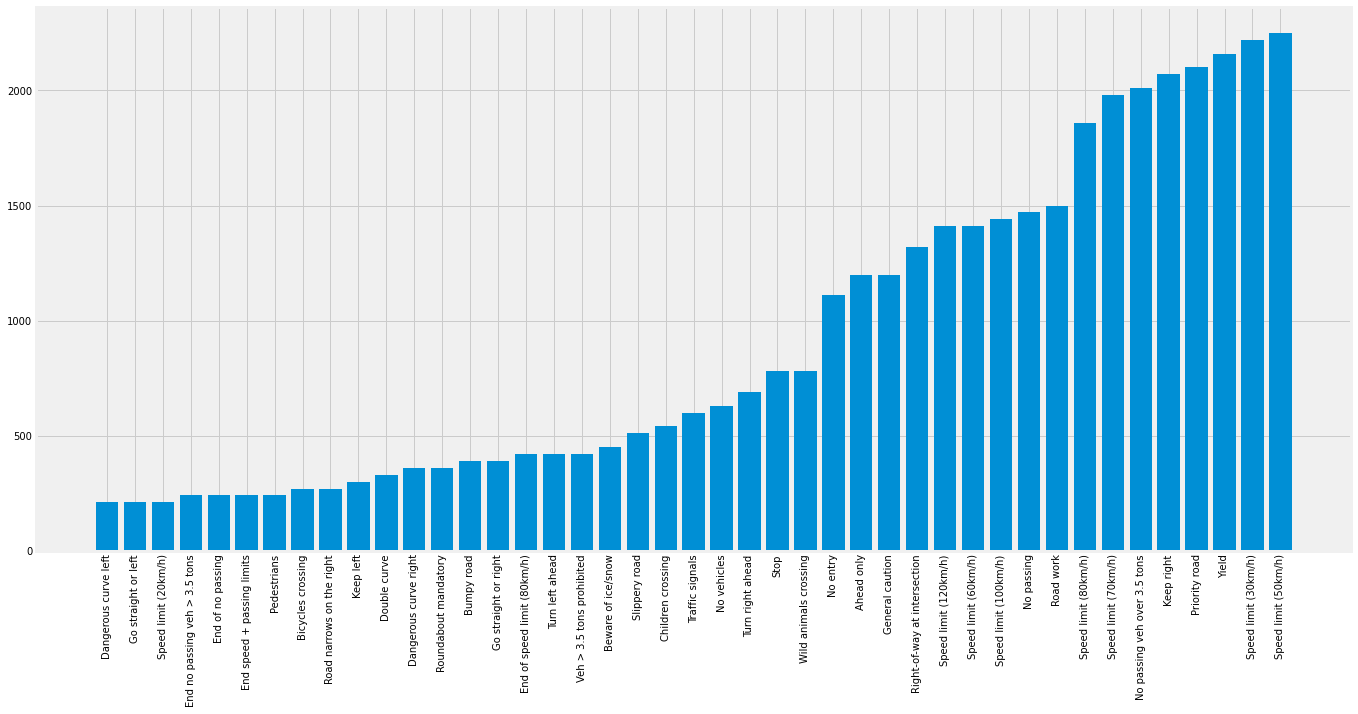

In [ ]:
folders = os.listdir(train_path)

train_number = []
class_num = []

for folder in folders:
    train_files = os.listdir(train_path + '/' + folder)
    train_number.append(len(train_files))
    class_num.append(classes[int(folder)])
    
# Сортируем набор данных по количеству изображений в каждом классе
zipped_lists = zip(train_number, class_num)
sorted_pairs = sorted(zipped_lists)
tuples = zip(*sorted_pairs)
train_number, class_num = [ list(tuple) for tuple in  tuples]

# Визуализация количества изображений в классах на графике
plt.figure(figsize=(21,10))  
plt.bar(class_num, train_number)
plt.xticks(class_num, rotation='vertical')
plt.show()

Визуализируем 25 случайных изображений из набора данных для тестирования нейросети:

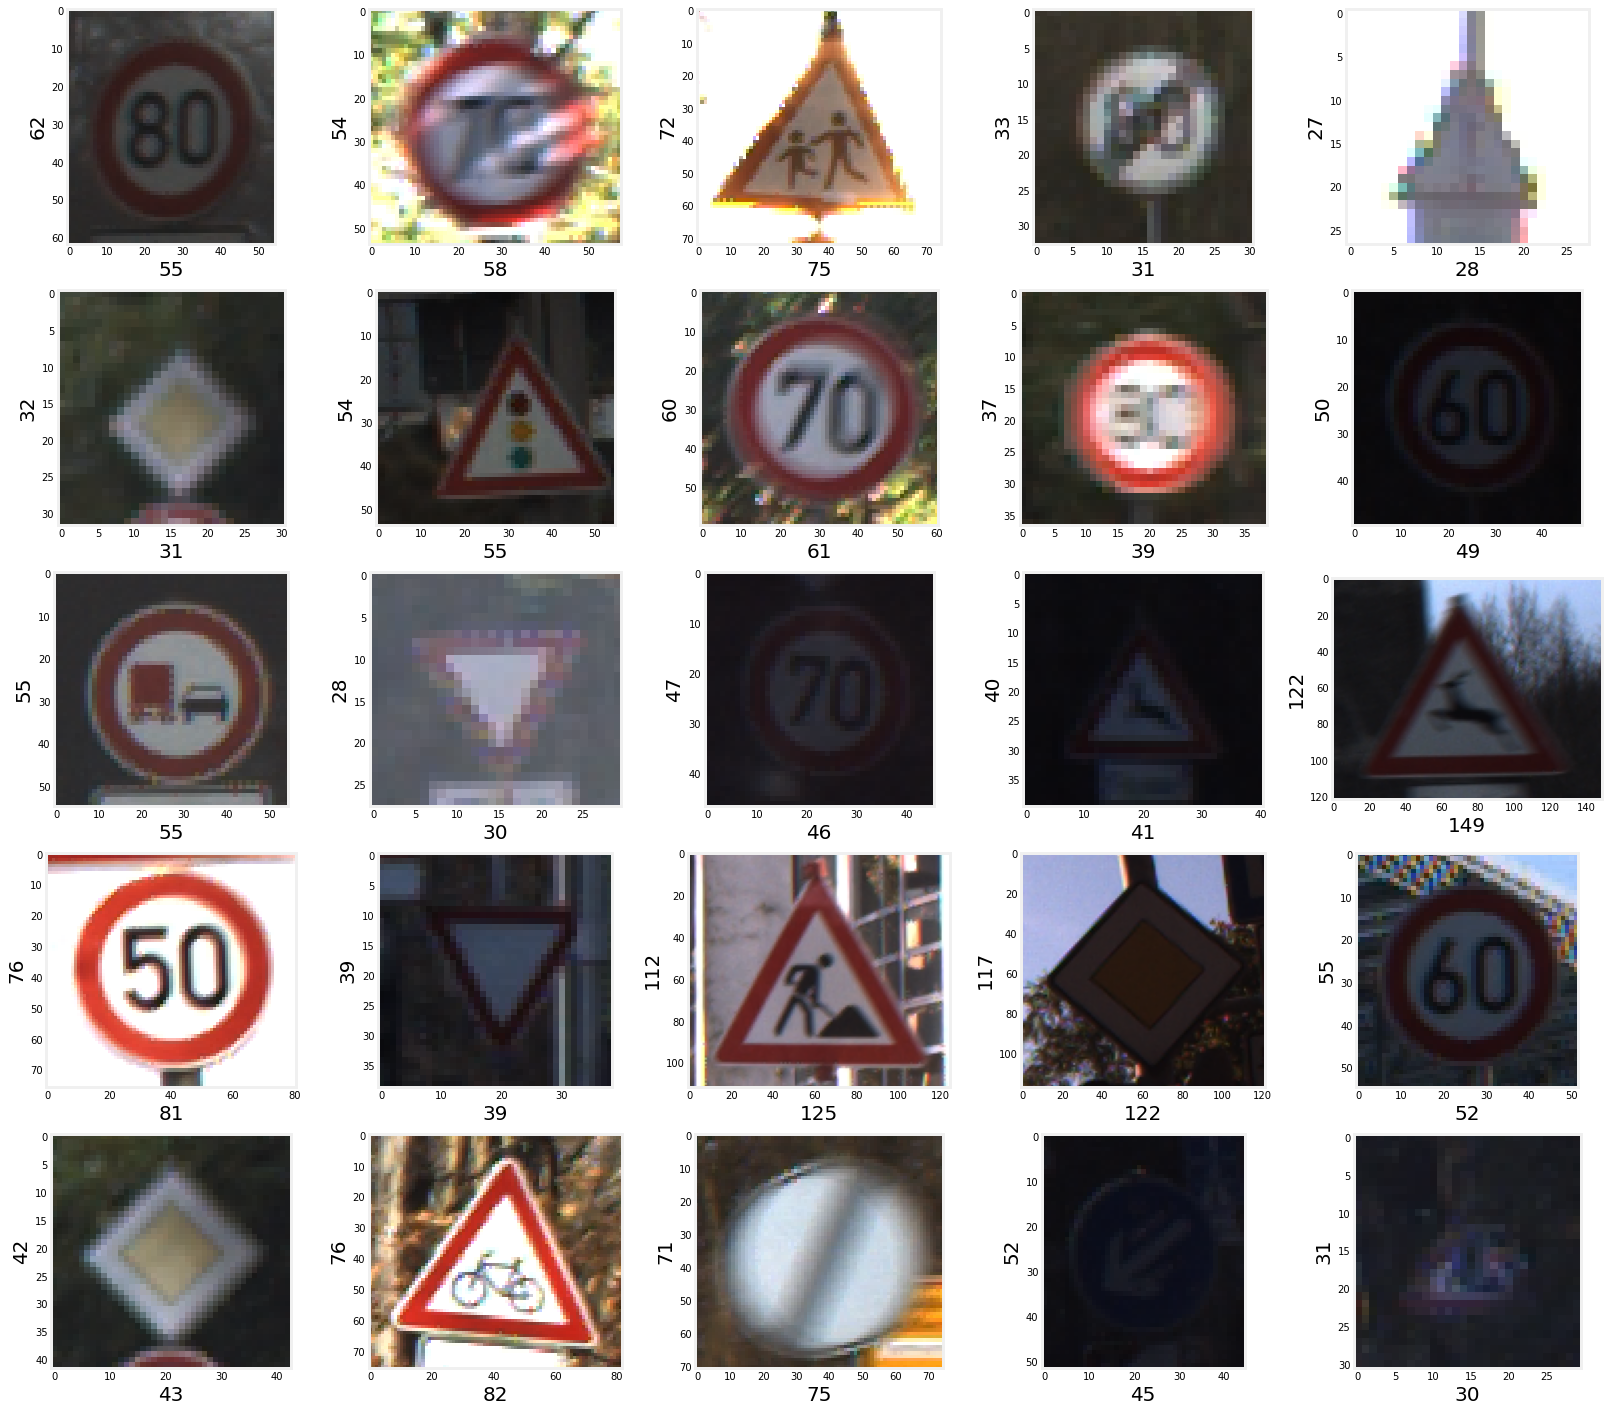

In [ ]:
test = pd.read_csv(data_dir + '/Test.csv')
imgs = test["Path"].values

plt.figure(figsize=(25,25))

for i in range(1,26):
    plt.subplot(5,5,i)
    random_img_path = data_dir + '/' + random.choice(imgs)
    rand_img = imread(random_img_path)
    plt.imshow(rand_img)
    plt.grid(b=None)
    plt.xlabel(rand_img.shape[1], fontsize = 20)
    plt.ylabel(rand_img.shape[0], fontsize = 20)

Загружаем данные для обучения:

In [ ]:
image_data = []
image_labels = []

for i in range(classes_amount):
    path = data_dir + '/Train/' + str(i)
    images = os.listdir(path)

    for img in images:
        try:
            image = cv2.imread(path + '/' + img)[...,::-1]
            image_fromarray = Image.fromarray(image, 'RGB')
            resize_image = image_fromarray.resize((image_height, image_width))
            image_data.append(np.array(resize_image))
            image_labels.append(i)
        except:
            print("Error in " + img)

# Приводим список к numpy массиву
image_data = np.array(image_data)
image_labels = np.array(image_labels)

Перемешаем данные для обучения:

In [ ]:
shuffle_indexes = np.arange(image_data.shape[0])
np.random.shuffle(shuffle_indexes)
image_data = image_data[shuffle_indexes]
image_labels = image_labels[shuffle_indexes]

Разделим данные на 2 группы, для обучения и для валидации:

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(image_data, image_labels, test_size=0.3, random_state=42, shuffle=True)

Нормализуем данные:

In [ ]:
X_train = X_train/255 
X_val = X_val/255

Преобразуем правильные ответы в формат one hot encoding:

In [ ]:
y_train = keras.utils.to_categorical(y_train, classes_amount)
y_val = keras.utils.to_categorical(y_val, classes_amount)

## Создание нейросети

In [ ]:
# Создаем последовательную модель
model = keras.models.Sequential()
# Первый сверточный слой
model.add(keras.layers.Conv2D(filters=16, kernel_size=(3,3), activation='relu', input_shape=(image_height,image_width,channels)))
# Второй сверточный слой
model.add(keras.layers.Conv2D(filters=32, kernel_size=(3,3), activation='relu'))
# Первый слой подвыборки
model.add(keras.layers.MaxPool2D(pool_size=(2, 2)))
# Слой нормализации 
model.add(keras.layers.BatchNormalization(axis=-1))
# Третий сверточный слой
model.add(keras.layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu'))
# Четвертый сверточный слой
model.add(keras.layers.Conv2D(filters=128, kernel_size=(3,3), activation='relu'))
# Второй слой подвыборки
model.add(keras.layers.MaxPool2D(pool_size=(2, 2)))
# Слой нормализации 
model.add(keras.layers.BatchNormalization(axis=-1))
# Слой преобразования данных из 2D представления в плоское
model.add(keras.layers.Flatten())
# Полносвязный слой для классификации
model.add(keras.layers.Dense(512, activation='relu'))
# Слой нормализации 
model.add(keras.layers.BatchNormalization())
# Слой регуляризации Dropout
model.add(keras.layers.Dropout(0.5))
# Выходной полносвязный слой
model.add(keras.layers.Dense(classes_amount, activation='softmax'))

Выводим информацию о созданной сети:

In [ ]:
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 30, 30, 16)        448       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 32)        4640      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 32)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 14, 14, 32)        128       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 12, 12, 64)        18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 10, 10, 128)       73856     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 128)         0

Компилируем модель:

In [ ]:
# Количество эпох для обучения
epochs = 30
model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=0.001, decay=0.001 / (epochs * 0.5)), metrics=['accuracy'])

Визуализируем модель:

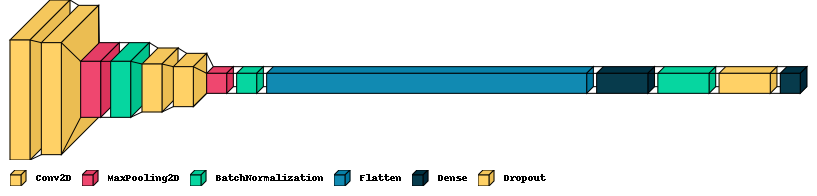

In [ ]:
visualkeras.layered_view(model, legend=True)

Аугментация данных для обучения нейросети:

In [ ]:
aug = ImageDataGenerator(
    rotation_range=10,
    zoom_range=0.15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.15,
    horizontal_flip=False,
    vertical_flip=False,
    fill_mode="nearest")

## Обучаем нейронную сеть

In [27]:
history = model.fit(aug.flow(X_train, y_train, batch_size=32), epochs=epochs, validation_data=(X_val, y_val))

Epoch 1/30
858/858 [==============================] - 18s 21ms/step - loss: 1.0278 - accuracy: 0.7205 - val_loss: 0.0567 - val_accuracy: 0.9845
Epoch 2/30
858/858 [==============================] - 17s 20ms/step - loss: 0.1528 - accuracy: 0.9549 - val_loss: 0.0201 - val_accuracy: 0.9948
Epoch 3/30
858/858 [==============================] - 17s 20ms/step - loss: 0.0886 - accuracy: 0.9734 - val_loss: 0.0303 - val_accuracy: 0.9912
Epoch 4/30
858/858 [==============================] - 17s 20ms/step - loss: 0.0690 - accuracy: 0.9783 - val_loss: 0.0116 - val_accuracy: 0.9966
Epoch 5/30
858/858 [==============================] - 18s 20ms/step - loss: 0.0627 - accuracy: 0.9803 - val_loss: 0.0114 - val_accuracy: 0.9969
Epoch 6/30
858/858 [==============================] - 17s 20ms/step - loss: 0.0487 - accuracy: 0.9847 - val_loss: 0.0092 - val_accuracy: 0.9971
Epoch 7/30
858/858 [==============================] - 18s 21ms/step - loss: 0.0361 - accuracy: 0.9888 - val_loss: 0.0119 - val_accuracy:

## Сохраняем нейронную сеть для последующего использования

In [ ]:
model.save('TrafficSignRecognitionCNN')

INFO:tensorflow:Assets written to: TrafficSignRecognitionCNN/assets


## Оцениваем качество обучения сети

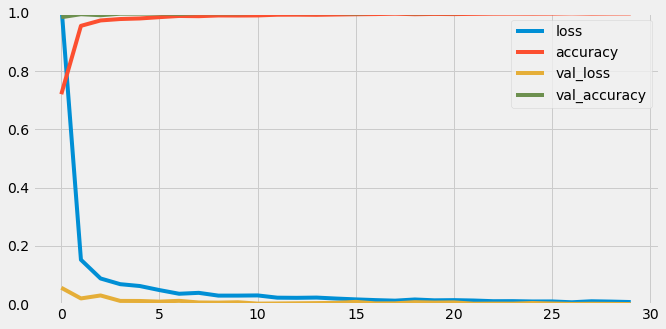

In [28]:
pd.DataFrame(history.history).plot(figsize=(10, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

Проверка качества работы нейросети на наборе данных для тестирования:

In [29]:
test = pd.read_csv(data_dir + '/Test.csv')

labels = test["ClassId"].values
imgs = test["Path"].values

data =[]

for img in imgs:
    try:
        image = cv2.imread(data_dir + '/' +img)[...,::-1]
        image_fromarray = Image.fromarray(image, 'RGB')
        resize_image = image_fromarray.resize((image_height, image_width))
        data.append(np.array(resize_image))
    except:
        print("Error in " + img)
X_test = np.array(data)
# Нормализация тестовых данных
X_test = X_test/255

pred = np.argmax(model.predict(X_test), axis=-1)

print('Доля верных ответов на тестовых данных, в процентах: ', accuracy_score(labels, pred)*100 )

Доля верных ответов на тестовых данных, в процентах:  98.70942201108473


Распознавание, знаков из тестового набора с визуализацией:

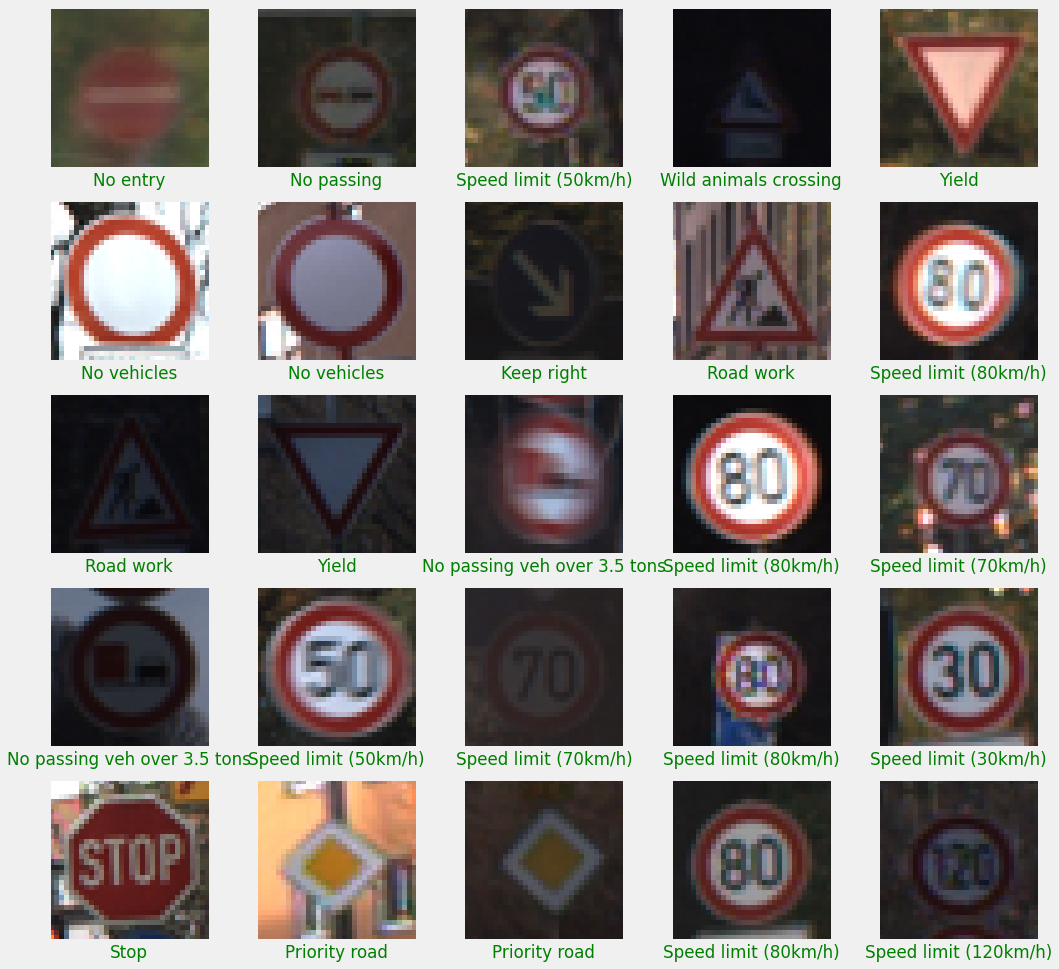

In [34]:
plt.figure(figsize = (16, 16))

start_index = random.randint(0,1000)
for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    prediction = pred[start_index + i]
    actual = labels[start_index + i]
    col = 'g'
    if prediction != actual:
        col = 'r'
    plt.xlabel('{}'.format(classes[prediction]), color = col)
    plt.imshow(X_test[start_index + i])
plt.show()

## Загрузка своей картинки

In [ ]:
files.upload()

NameError: ignored

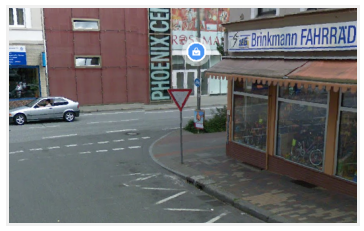

[13]
Its a Yield


In [ ]:
img_path = '12345.png'
data =[]
image = cv2.imread(img_path)[...,::-1]
plt.imshow(image)
plt.grid(False)
plt.xticks([])
plt.yticks([])
plt.show()
image_fromarray = Image.fromarray(image, 'RGB')
resize_image = image_fromarray.resize((image_height, image_width))
data.append(np.array(resize_image))
x = np.array(data)
# Нормализация тестовых данных
x = x/255
pred = np.argmax(model.predict(x), axis=-1)
print(pred)
print("Its a",classes[pred[0]])